In [ ]:
import os

import torch
import torch.nn as nn
import torchvision
from matplotlib import pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
BS = 256
LR = 5e-5
NOISE_DIM = 100
EMBEDDING_DIM = 50
IMAGE_SIZE = (32, 32)
NUM_CHANNELS = 1
NUM_EPOCHS = 10
IMAGE_DIR = 'generated-images'
DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(DEVICE)

cuda


In [ ]:
class Generator(nn.Module):
    def __init__(self, in_dim, out_dim, emb_dim):
        super().__init__()
        self.in_dim = in_dim
        self.emb = nn.Embedding(10, emb_dim)
        self.ll = nn.Linear(emb_dim, 100)
        self.model = nn.Sequential(
            nn.ConvTranspose2d(self.in_dim*2, 512, 4, 1, 0, bias=False),  # 4 x 4
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),  # 8 x 8
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),  # 16 x 16
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, out_dim, 4, 2, 1),  # 32 x 32
            nn.Tanh()
        )

    def forward(self, x, y):
        y = self.ll(self.emb(y))
        xy = torch.concat([x, y], dim=1)
        xy = xy.view(-1, self.in_dim*2, 1, 1)
        return self.model(xy)


class Discriminator(nn.Module):
    def __init__(self, in_dim, out_dim, emb_dim):
        super().__init__()
        self.emb = nn.Embedding(10, emb_dim)
        self.ll = nn.Linear(emb_dim, 32*32)
        self.model = nn.Sequential(
            nn.Conv2d(in_dim+1, 128, 4, 2, 1, bias=False),  # 16 x 16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.01),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),  # 8 x 8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.01),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),  # 4 x 4
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.01),
            nn.Flatten(),
            nn.Linear(512 * 4 * 4, out_dim),
            nn.Sigmoid()
        )

    def forward(self, x, y):
        y = self.ll(self.emb(y))
        y = y.view(-1, 1, 32, 32)
        xy = torch.concat([x, y], dim=1)
        return self.model(xy)


def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

# Initialize generator and discriminator
generator = Generator(NOISE_DIM, NUM_CHANNELS, EMBEDDING_DIM).to(DEVICE)
discriminator = Discriminator(NUM_CHANNELS, 1, EMBEDDING_DIM).to(DEVICE)
initialize_weights(generator)
initialize_weights(discriminator)
fixed_noise = torch.randn(BS, NOISE_DIM).to(DEVICE)

# Loss & Optimizer
loss = nn.BCELoss()
opt_gen = torch.optim.Adam(generator.parameters(), lr=LR, betas=(0.5, 0.999))
opt_dis = torch.optim.Adam(discriminator.parameters(), lr=LR, betas=(0.5, 0.999))

In [ ]:
# initializing dataloader
tfms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.MNIST(root='data/', download=True, transform=tfms)
dataloader = DataLoader(dataset, shuffle=True, batch_size=BS, drop_last=True)

# Initialize the lists to store the losses
d_losses = []
g_losses = []

# Create the directory to save the generated images
if not os.path.exists(IMAGE_DIR):
    os.makedirs(IMAGE_DIR)

step = 0

for epoch in range(NUM_EPOCHS):
    for i, (xb, yb) in enumerate(dataloader):
        # Data
        real_img = xb.to(DEVICE)
        real_label = yb.to(DEVICE)
        noise = torch.randn(BS, 100).to(DEVICE)
        fake_label = torch.randint(10, (BS,)).to(DEVICE)

        fake_img = generator(noise, fake_label)
        # noise = torch.randn(n_samples, 100).to(DEVICE)
        # fake_label = torch.ones((n_samples,)) * 6

        # Discriminator
        dis_fake = discriminator(fake_img.detach(), fake_label) # important
        dis_real = discriminator(real_img, real_label)

        loss_fake = loss(dis_fake, torch.zeros_like(dis_fake))
        loss_real = loss(dis_real, torch.ones_like(dis_real))
        loss_dis = loss_fake + loss_real
        opt_dis.zero_grad()
        loss_dis.backward()
        opt_dis.step()

        # Generator
        dis_fake = discriminator(fake_img, fake_label)
        loss_gen = loss(dis_fake, torch.ones_like(dis_fake))
        opt_gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()
    
        d_losses.append(loss_dis.item())
        g_losses.append(loss_gen.item())

        if i % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Discriminator Loss: {:.4f}, Generator Loss: {:.4f}'
                  .format(epoch + 1, NUM_EPOCHS, i + 1, len(dataloader), loss_dis.item(), loss_gen.item()))

            # display the 8 fake images to IMAGE_DIR
            torchvision.utils.save_image(fake_img[:8], os.path.join(IMAGE_DIR, f'{epoch}_{i}.png'), nrow=8)


Epoch [1/10], Step [1/234], Discriminator Loss: 1.3876, Generator Loss: 0.6958
Epoch [1/10], Step [101/234], Discriminator Loss: 0.5473, Generator Loss: 1.5219
Epoch [1/10], Step [201/234], Discriminator Loss: 0.1657, Generator Loss: 2.6174
Epoch [2/10], Step [1/234], Discriminator Loss: 0.1194, Generator Loss: 2.9268
Epoch [2/10], Step [101/234], Discriminator Loss: 0.0559, Generator Loss: 3.6587
Epoch [2/10], Step [201/234], Discriminator Loss: 0.0318, Generator Loss: 4.2027
Epoch [3/10], Step [1/234], Discriminator Loss: 0.0268, Generator Loss: 4.3593
Epoch [3/10], Step [101/234], Discriminator Loss: 0.0182, Generator Loss: 4.7585
Epoch [3/10], Step [201/234], Discriminator Loss: 0.0159, Generator Loss: 5.0499
Epoch [4/10], Step [1/234], Discriminator Loss: 0.0143, Generator Loss: 5.0950
Epoch [4/10], Step [101/234], Discriminator Loss: 0.0476, Generator Loss: 3.9264
Epoch [4/10], Step [201/234], Discriminator Loss: 0.2408, Generator Loss: 2.6620
Epoch [5/10], Step [1/234], Discrimi

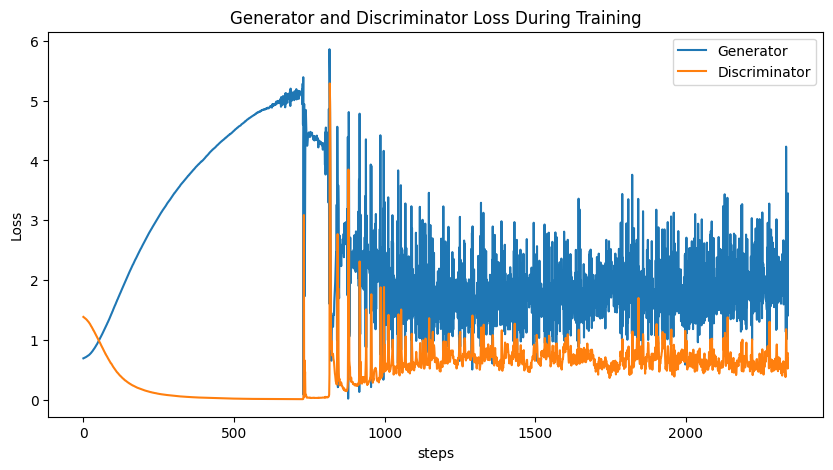

In [ ]:
# plot the losses
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_losses, label="Generator")
plt.plot(d_losses, label="Discriminator")
plt.xlabel("steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

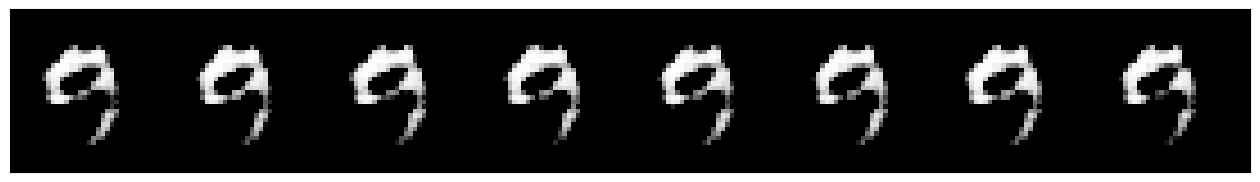

In [ ]:
n_samples = 8
noise = torch.randn(n_samples, 100).to(DEVICE)
# fake_label = torch.randint(10, (n_samples,)).to(DEVICE)
fake_label = torch.ones((n_samples, )).long().to(DEVICE) * 9
        
fake_img = generator(noise, fake_label)
fig, ax = plt.subplots(figsize=(16, 8))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(
    torchvision.utils.make_grid(
        fake_img.view(-1, 1, 32, 32).detach().cpu(), nrow=8).permute(1, 2, 0))


## Visualizing the network

In [ ]:
# !apt-get install graphviz
# !pip install torchview

In [ ]:
# import graphviz
# graphviz.set_jupyter_format('png')

# from torchview import draw_graph

'svg'

In [ ]:
# batch_size = 2
# generator_graph = draw_graph(generator.model, input_size=(batch_size, 200, 1, 1), device='meta')
# generator_graph.visual_graph

In [ ]:
# discriminator_graph = draw_graph(discriminator.model, input_size=(batch_size, 2, 32, 32), device='meta')
# discriminator_graph.visual_graph

## Training MNIST model

In [ ]:
from torch.nn import functional as F

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()


In [ ]:
## MNIST model with dataloader

tfms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.GaussianBlur(7),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='data/', download=True, transform=tfms)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=BS)

test_dataset = datasets.MNIST(root='data/', download=True, train=False, transform=tfms)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=BS*2)


model.train()
for epoch in range(3):
    for batch_idx, (data, target) in enumerate(train_dataloader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx}/{len(train_dataloader)}]\tLoss: {loss.item():.6f}')

for batch_idx, (data, target) in enumerate(test_dataloader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_dataloader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            test_loss += loss_fn(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

print(f'\nTest Accuracy: {correct}/{len(test_dataloader.dataset)}')


Train Epoch: 0 [0/235]	Loss: 0.120889
Train Epoch: 0 [100/235]	Loss: 0.095055
Train Epoch: 0 [200/235]	Loss: 0.051309
Train Epoch: 1 [0/235]	Loss: 0.060697
Train Epoch: 1 [100/235]	Loss: 0.100715
Train Epoch: 1 [200/235]	Loss: 0.057005
Train Epoch: 2 [0/235]	Loss: 0.062872
Train Epoch: 2 [100/235]	Loss: 0.291058
Train Epoch: 2 [200/235]	Loss: 0.059544

Test Accuracy: 9898/10000


In [ ]:
## MNIST model with Generator's Output

n_samples = BS
model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


model.train()
for epoch in range(3):
    for batch_idx in range(len(train_dataloader)):
        noise = torch.randn(n_samples, 100).to(DEVICE)
        target = torch.randint(10, (n_samples,)).to(DEVICE)
        data = generator(noise, target)
        # data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx}/{len(train_dataloader)}]\tLoss: {loss.item():.6f}')

for batch_idx, (data, target) in enumerate(test_dataloader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_dataloader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            test_loss += loss_fn(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

print(f'\nTest Accuracy: {correct}/{len(test_dataloader.dataset)}')


Train Epoch: 0 [0/235]	Loss: 2.291031
Train Epoch: 0 [100/235]	Loss: 0.003921
Train Epoch: 0 [200/235]	Loss: 0.003379
Train Epoch: 1 [0/235]	Loss: 0.002014
Train Epoch: 1 [100/235]	Loss: 0.003725
Train Epoch: 1 [200/235]	Loss: 0.000141
Train Epoch: 2 [0/235]	Loss: 0.001032
Train Epoch: 2 [100/235]	Loss: 0.002381
Train Epoch: 2 [200/235]	Loss: 0.000575

Test Accuracy: 4242/10000
